Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

#from nltk.tokenize import sent_tokenize, word_tokenize
#from nltk.corpus import stopwords

# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

Data Imports

In [2]:
kaggle_train_df = pd.read_csv("data/train.csv", header=0, sep=",")
kaggle_test_df = pd.read_csv("data/test.csv", header=0, sep=",")
kaggle_sample_submission_df = pd.read_csv("data/sample_submission.csv", header=0, sep=",")

In [3]:
display(kaggle_train_df.head())
display(kaggle_test_df.head())
display(kaggle_sample_submission_df.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [4]:
for df, lbl in zip([kaggle_train_df, kaggle_test_df, kaggle_sample_submission_df], ["kaggle_train_df", "kaggle_test_df", "kaggle_sample_submission_df"]):
    print(lbl)
    print(f"\tshape:{df.shape}")
    for var in df.columns.tolist():
        print(f"\t{var} | {df[var].isna().sum()} NA | {df[var].dtypes}")

# kaggle_train_df["target"] = kaggle_train_df["target"].astype(str) #For some reason this needs to be text for Keras's binary classification

kaggle_train_df
	shape:(7613, 5)
	id | 0 NA | int64
	keyword | 61 NA | object
	location | 2533 NA | object
	text | 0 NA | object
	target | 0 NA | int64
kaggle_test_df
	shape:(3263, 4)
	id | 0 NA | int64
	keyword | 26 NA | object
	location | 1105 NA | object
	text | 0 NA | object
kaggle_sample_submission_df
	shape:(3263, 2)
	id | 0 NA | int64
	target | 0 NA | int64


#### Brief description of the problem and data
<b>Data Description:</b><br>

| | Kaggle Train Data | Kaggle Test Data | Kaggle Sample Submission Data |
| :-- | :-- | :-- | :-- |
| Num Rows | 7613 | 3263 | 3263 |
| Num Cols | 5 | 4 | 2 |
| Dimension | 2 | 2 | 1 (+ id) |
| # Missing (id) | 0 | 0 | 0 |
| # Missing (keyword) | 61 | 26 | --- |
| # Missing (location) | 2533 | 1105 | --- |
| # Missing (text) | 0 | 0 | --- |
| # Missing (target) | 0 | 0 | 0 |

The data is primarily unique identifier keys (id), human-generated text strings (text) which is disproprtionately filled with hash tags, and a binary indicator (target) of whether or not the text is associated with a disaster event.<br>
There are also keyword and location variables, but both of these have missing observations. (Approximately a third of the location data is missing, and fidelity is unknown.)<br>
<br>
<b>Problem Description: </b> Create a binary classifier from the text data that can predict whether or not the text is associated with a disaster. Difficulty arises from complexities of natural language such as euphamistic use of phrases associated with disasters and contextual clues regarding severity of described events.

#### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [5]:
#Copy the training and testing data, sans the columns which have missing data.
train_df = kaggle_train_df[["id", "text", "target"]].copy()
test_df = kaggle_test_df[["id", "text"]].copy()

#Keep only letters and spaces in the text strings because I don't want to deal with hash tags or punctuation
#Also convert to lower case because that'll play nicer with text processing tools
def lower_alpha(raw):
    alpha = "".join([c for c in raw if (c.isalpha()) or (c == " ")])
    lower_alpha = alpha.lower()
    return lower_alpha

train_df["text"] = train_df["text"].apply(lambda raw: lower_alpha(raw))
test_df["text"] = test_df["text"].apply(lambda raw: lower_alpha(raw))

display(train_df.head(5))
display(test_df.head(5))

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,people receive wildfires evacuation orders in...,1
4,7,just got sent this photo from ruby alaska as s...,1


,id,text
0,0,just happened a terrible car crash
1,2,heard about earthquake is different cities sta...
2,3,there is a forest fire at spot pond geese are ...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills in china and taiwan


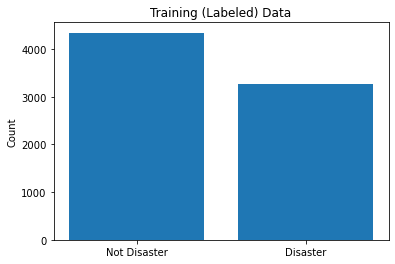

In [6]:
categories = ["Not Disaster", "Disaster"]
train_counts_df = train_df.groupby(["target"]).size()
y_pos = train_counts_df.index.tolist()
counts = train_counts_df.tolist()

plt.bar(y_pos, counts, align = "center")
plt.xticks(y_pos, categories)
plt.ylabel("Count")
plt.title("Training (Labeled) Data")
plt.show()


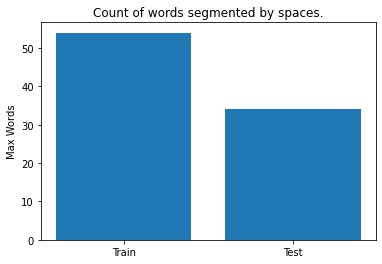

In [7]:
max_train_word_count = max([len(s.split(" ")) for s in train_df["text"].tolist()])
max_test_word_count = max([len(s.split(" ")) for s in test_df["text"].tolist()])

categories = ["Train", "Test"]
y_pos = [0,1]
counts = [max_train_word_count, max_test_word_count]

plt.bar(y_pos, counts, align = "center")
plt.xticks(y_pos, categories)
plt.ylabel("Max Words")
plt.title("Count of words segmented by spaces.")
plt.show()

max_padding = max(max_train_word_count, max_test_word_count)+1
#max_padding will be used when the tokenized data is padded and will prevent us from making the padding larger than necessary

In [8]:
#Perform the train/test split on the train_df data
text_train, text_test, lbl_train, lbl_test = train_test_split(
    train_df["text"].tolist(), 
    train_df["target"].tolist(), 
    test_size = 0.2, 
    random_state = 0)

#Tokenize, pad, and get copies into standard nomenclature
#Tokenize
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(text_train)

vocabulary_count = 1 + len(tokenizer.word_index) #The '1+' is because the zero position index is reserved

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

#Pad
X_train = pad_sequences(X_train, padding = "post", maxlen = max_padding)
X_test = pad_sequences(X_test, padding = "post", maxlen = max_padding)

y_train = np.array(lbl_train)
y_test = np.array(lbl_test)

#### Model Architecture
This section of the course is centered on recurrent neural networks, so we're going to focus on an LSTM.<br>
We'll test iteratively with two optimizers (Adam and gradient descent), two embedding output dimensions (25 and 50), two LSTM layer sizes (50 and 100), and two sizes (10 and 25) of dense layers before the final dense layer.<br>
Even with a 12GB RTX 3060 letting CUDA do the heavy lifting, this takes a while.

In [9]:
input_dimension = vocabulary_count
input_length = max_padding

optimizers = ["Adam", "SGD"]
output_dimensions = [25, 50]
first_layer_sizes = [50,100]
second_layer_sizes = [10,25]

num_epochs = 10
batch_size = 100

model_dumps = []

parameters = [i for i in itertools.product(optimizers, output_dimensions, first_layer_sizes, second_layer_sizes)]

for param in parameters:
    print(param)
    clear_session()

    model = Sequential()
    model.add(layers.Embedding(
        input_dim = input_dimension, 
        output_dim = param[1], 
        mask_zero = True
    ))
    model.add(layers.Bidirectional(layers.LSTM(param[2])))
    model.add(layers.Dense(param[3], activation = "relu"))
    model.add(layers.Dense(1, activation = "sigmoid"))
    model.compile(optimizer = param[0], 
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])

    history = model.fit(
        X_train, 
        y_train, 
        epochs = num_epochs, 
        verbose = False, 
        validation_data = (X_test, y_test), 
        batch_size = batch_size)

    training_loss, training_accuracy = model.evaluate(X_train, y_train, verbose = False)
    testing_loss, testing_accuracy = model.evaluate(X_test, y_test, verbose = False)

    model_dumps.append({
        "history": history,
        "parameters": param,
        "training_loss": training_loss,        
        "testing_loss": testing_loss,
        "training_accuracy": training_accuracy,        
        "testing_accuracy": testing_accuracy,
    })

('Adam', 25, 50, 10)
('Adam', 25, 50, 25)
('Adam', 25, 100, 10)
('Adam', 25, 100, 25)
('Adam', 50, 50, 10)
('Adam', 50, 50, 25)
('Adam', 50, 100, 10)
('Adam', 50, 100, 25)
('SGD', 25, 50, 10)
('SGD', 25, 50, 25)
('SGD', 25, 100, 10)
('SGD', 25, 100, 25)
('SGD', 50, 50, 10)
('SGD', 50, 50, 25)
('SGD', 50, 100, 10)
('SGD', 50, 100, 25)


#### Results and Analysis

In [10]:
comparison = pd.DataFrame(
    {"Parameters":[m['parameters'] for m in model_dumps],
     "Training_Accuracy":[m['training_accuracy'] for m in model_dumps],
     "Testing_Accuracy":[m['testing_accuracy'] for m in model_dumps]     
    })
display(comparison)

,Parameters,Training_Accuracy,Testing_Accuracy
0,"(Adam, 25, 50, 10)",0.925123,0.795798
1,"(Adam, 25, 50, 25)",0.948276,0.782009
2,"(Adam, 25, 100, 10)",0.949754,0.789232
3,"(Adam, 25, 100, 25)",0.944828,0.785292
4,"(Adam, 50, 50, 10)",0.919376,0.790545
5,"(Adam, 50, 50, 25)",0.961412,0.778070
6,"(Adam, 50, 100, 10)",0.933990,0.778070
7,"(Adam, 50, 100, 25)",0.959442,0.766251
8,"(SGD, 25, 50, 10)",0.567488,0.581747
9,"(SGD, 25, 50, 25)",0.567488,0.581747


Other than a clear distinction between optimizers, that's astonishingly little variation in training or testing accuracy.<br>
Let's look at some graphs to see if there's differences in the learning by epoch.

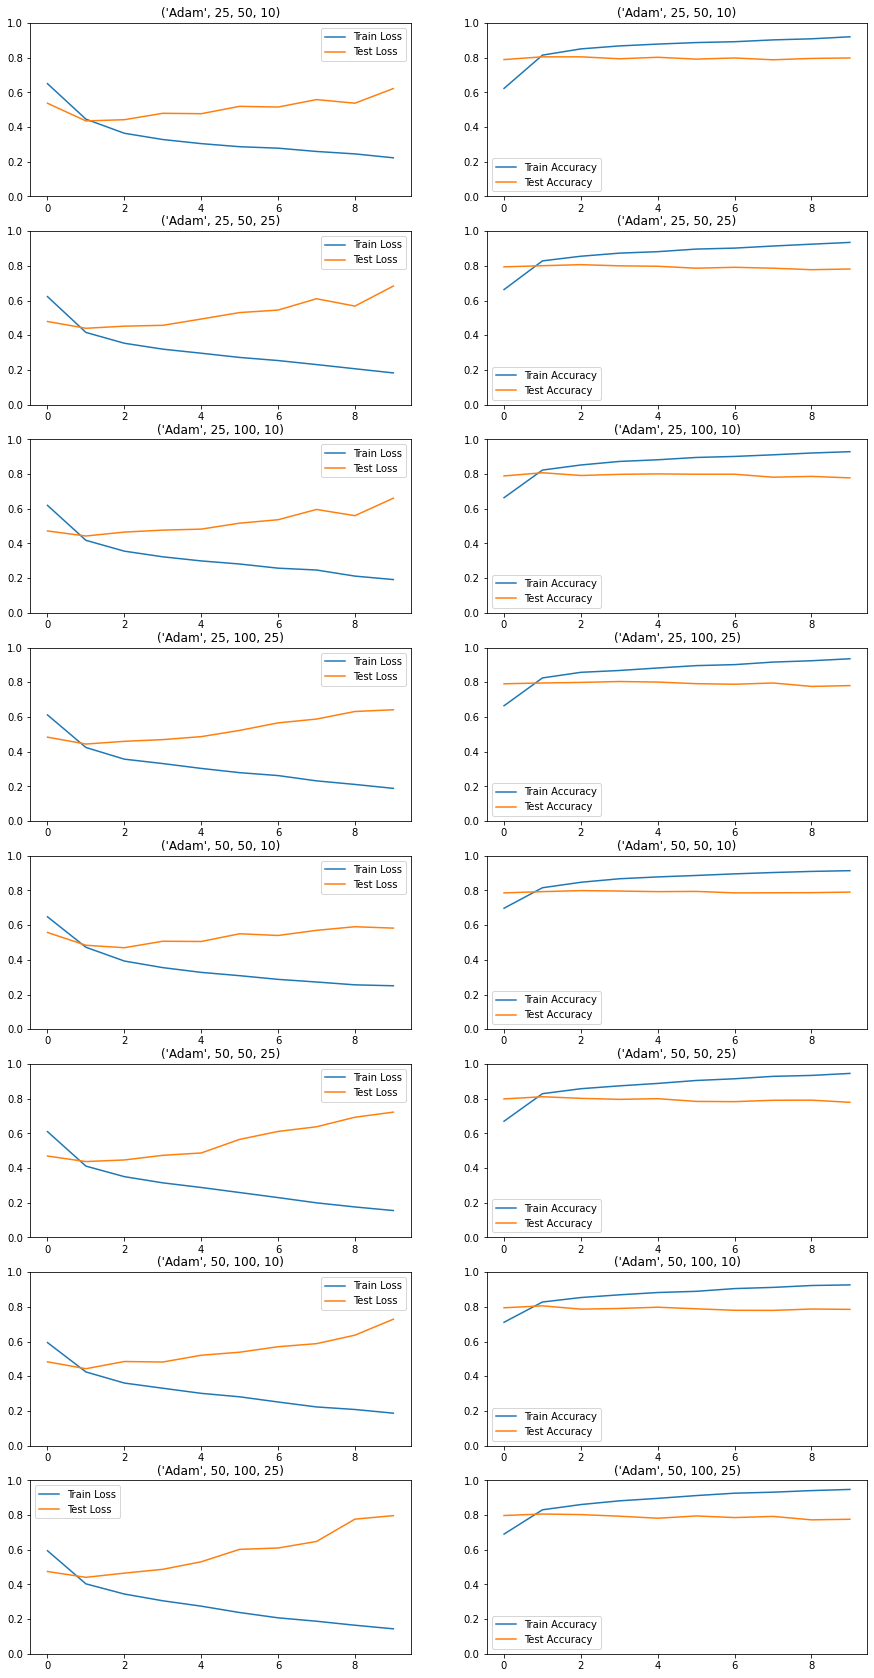

In [11]:
fig, axs = plt.subplots(8,2, figsize = (15,30))
for row in range(8):
    tmp_df = pd.DataFrame(model_dumps[row]["history"].history)
    axs[row,0].plot(tmp_df.index, tmp_df["loss"], label = "Train Loss")
    axs[row,0].plot(tmp_df.index, tmp_df["val_loss"], label = "Test Loss")
    axs[row,0].legend()
    axs[row,0].title.set_text(str(model_dumps[row]["parameters"]))
    axs[row,0].set_ylim([0,1])
    
    axs[row,1].plot(tmp_df.index, tmp_df["accuracy"], label = "Train Accuracy")
    axs[row,1].plot(tmp_df.index, tmp_df["val_accuracy"], label = "Test Accuracy")
    axs[row,1].legend()
    axs[row,1].title.set_text(str(model_dumps[row]["parameters"]))
    axs[row,1].set_ylim([0,1])
    
plt.show()

That's still rather little variation, so I'm going to pick the simplest model [index 0], run that on its own, and use it for the predicitons of the actual testing data.<br>
(I think the core problem with this approach is that Twitter is intrinsically a low-fidelity data source for individual observations because it's a stream-of-consciousness log for people who think posting on Twitter is a good idea. It's probably pretty useful if you aggregate users together in some meaningful fashion that's beyond the scope of this project or dataset.)

Rebuild the simplest model, then use it to predict the original test data and export the predictions for upload to Kaggle.

In [12]:
clear_session()

model = Sequential()
model.add(layers.Embedding(
    input_dim = input_dimension, 
    output_dim = 25, 
    mask_zero = True
))
model.add(layers.Bidirectional(layers.LSTM(50)))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))
model.compile(optimizer = "Adam", 
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

history = model.fit(
    X_train, 
    y_train, 
    epochs = num_epochs, 
    verbose = False, 
    validation_data = (X_test, y_test), 
    batch_size = batch_size)

In [13]:
kaggle_X_test = test_df["text"].tolist()
#Tokenize and pad the data for Kaggle
kaggle_X = tokenizer.texts_to_sequences(kaggle_X_test)
kaggle_X = pad_sequences(kaggle_X, padding ="post", maxlen = max_padding)
#Predict, round to binarize, and convert to int for compatibility.
predictions = model.predict(kaggle_X)
predictions = predictions.round().astype(int)

102/102 [==============================] - 2s 8ms/step


In [14]:
prediction_df = kaggle_sample_submission_df.copy()
prediction_df["target"] = predictions.flatten()

In [15]:
prediction_df.to_csv("submission.csv", header=True, sep=",", index=False)